# Using the SDFG API in DaCe

In this tutorial, we will create an SDFG manually using the SDFG API. This interface gives full control over the representation, and it is also the one used for developing new transformations and other graph manipulation.

The code we will write executes a stencil in a sequence (without boundary conditions). In SDFG terms, it is a sequential for-loop (state machine) of tasklets nested in maps.

In [1]:
import dace
import numpy as np

We begin by defining the temporal and spatial dimensions as symbols:

In [2]:
T = dace.symbol('T')
N = dace.symbol('N')

Creating an SDFG requires giving it a name (which will be used in compilation to create the library files and function names):

In [3]:
sdfg = dace.SDFG('jacobi2d')

Then, we need to define the set of data descriptors used throughout the Data nodes in the SDFG. Since we use a double-buffering approach, we define a 2D array `A` and a 2D array `tmp`. `tmp` is transient, which means it is not an input/output of the SDFG, and can thus participate in transformations.

In [4]:
sdfg.add_array('A', shape=[N, N], dtype=dace.float32)
sdfg.add_transient('tmp', shape=[N, N], dtype=dace.float32)

Array (dtype=float, shape=(N, N))

Next, we construct a state, which will contain the main computational part:

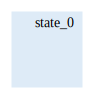

In [5]:
state = sdfg.add_state()
sdfg

Now the SDFG contains only one empty state. We will create the contents of the main state, which is two stencils, `A->tmp` and `tmp->A`. Since the code is equivalent, we define a function once and call it twice:

In [6]:
def mainstate(state, src_node, dst_node):
    # Creates Map (entry and exit nodes), Tasklet node, and connects the three
    tasklet, map_entry, map_exit = state.add_mapped_tasklet(
        '%s_to_%s' % (src_node.data, dst_node.data),        # name
        dict(i='1:N-1', j='1:N-1'),                         # map range
        dict(inp=dace.Memlet.simple(src_node.data,          # input memlets
                                    'i-1:i+2, j-1:j+2')),
        '''                                                 # code
out = 0.2 * (inp[0,1] + inp[1,0] + inp[1,1] +               # (5-point Jacobi)
              inp[1,2] + inp[2,1])
        ''',
        dict(out=dace.Memlet.simple(dst_node.data, 'i,j'))  # output memlets
    )
    
    #######################
    # Add external connections from map to arrays

    # Add input path (src->entry) with the overall memory accessed
    # NOTE: This can be inferred automatically by the system
    #       using external_edges=True in `add_mapped_tasklet`
    #       or using the `propagate_edge` function.
    state.add_edge(
        src_node, None,
        map_entry, None,
        memlet=dace.Memlet.simple(src_node.data, '0:N, 0:N'))
    
    # Add output path (exit->dst)
    state.add_edge(
        map_exit, None,
        dst_node, None,
        memlet=dace.Memlet.simple(dst_node.data, '1:N-1, 1:N-1'))

We add and connect the read, access (read/write), and write nodes for the main state, as well as the code:

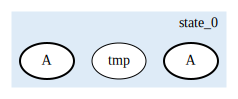

In [7]:
A_in = state.add_read('A')
tmp = state.add_access('tmp')
A_out = state.add_write('A')

sdfg

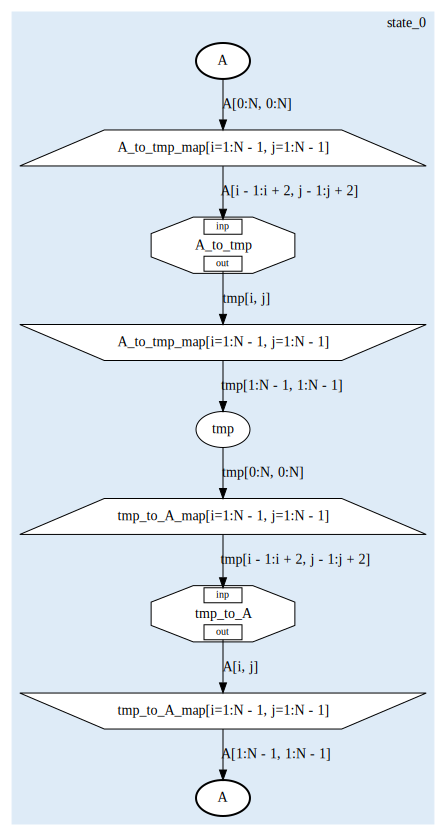

In [8]:
mainstate(state, A_in, tmp)
mainstate(state, tmp, A_out)
sdfg

Notice the boxes inside the tasklet nodes, connected to the edges. These are **connectors**, the way to identify the edge's behavior. A connector has a type and shape, just like arrays, and is also used to create unique paths through map scopes. 

In the above case, it is clear that the edges leading to and from the map entry/exit nodes form a path. However, when multiple edges are involved, it may be ambiguous. To uniquely identify paths, scope entry/exit nodes can have input connectors that begin with `IN_` and output connectors that begin with `OUT_`. As a convenience function, an SDFG can try to fill its scope connectors on its own (using the data names on the memlets):

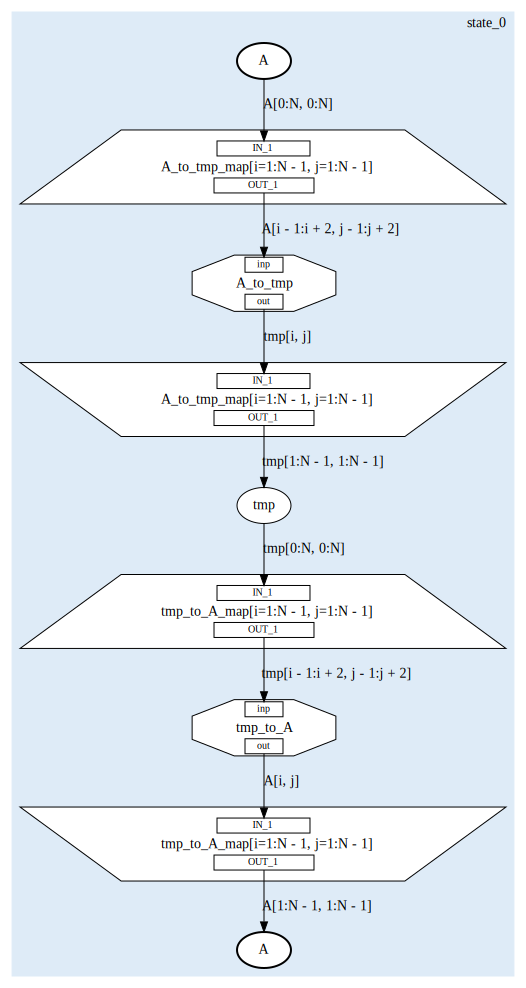

In [9]:
sdfg.fill_scope_connectors()
sdfg

This single-state SDFG is now valid, as no exceptions are raised below:

In [10]:
sdfg.validate()

However, it only runs for two time-steps, and will produce incorrect results, due to the boundaries of `tmp`. We thus need to define a starting state that sets `tmp` to zero, and a looping state machine. Initialization state is defined below:

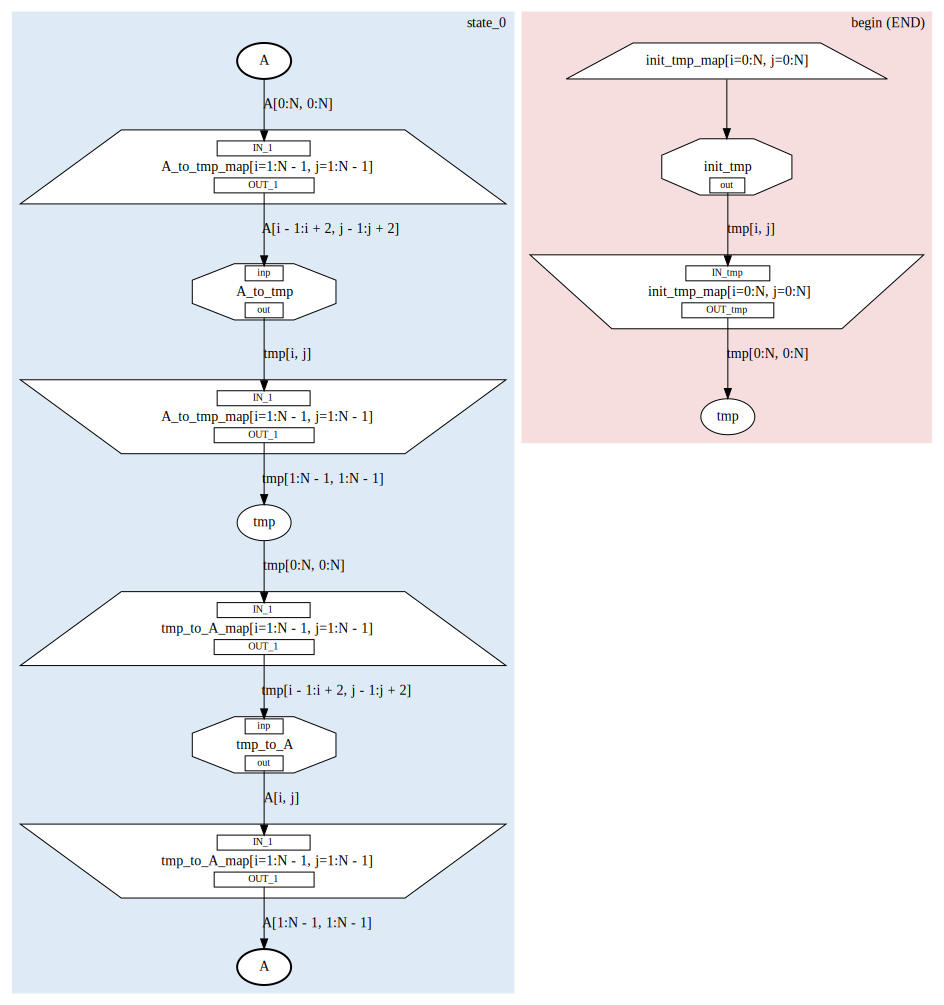

In [11]:
bstate = sdfg.add_state('begin') # States can be named
# We use the convenience parameter external_edges to add the tmp array node and connectors
bstate.add_mapped_tasklet('init_tmp', dict(i='0:N', j='0:N'), {}, # no inputs
                          'out = 0', dict(out=dace.Memlet.simple('tmp', 'i,j')),
                          external_edges=True)
sdfg

The loop will be defined in the same manner as C for-loops: A `guard` state, which jumps into the loop as long as it is in range; an `end` (empty) state; and the `loop` state (currently our main state), which jumps back to the guard and increments the iteration variable. Notice that adding edges on the SDFG (as opposed to adding them in states) requires a different edge object type: `InterstateEdge`.

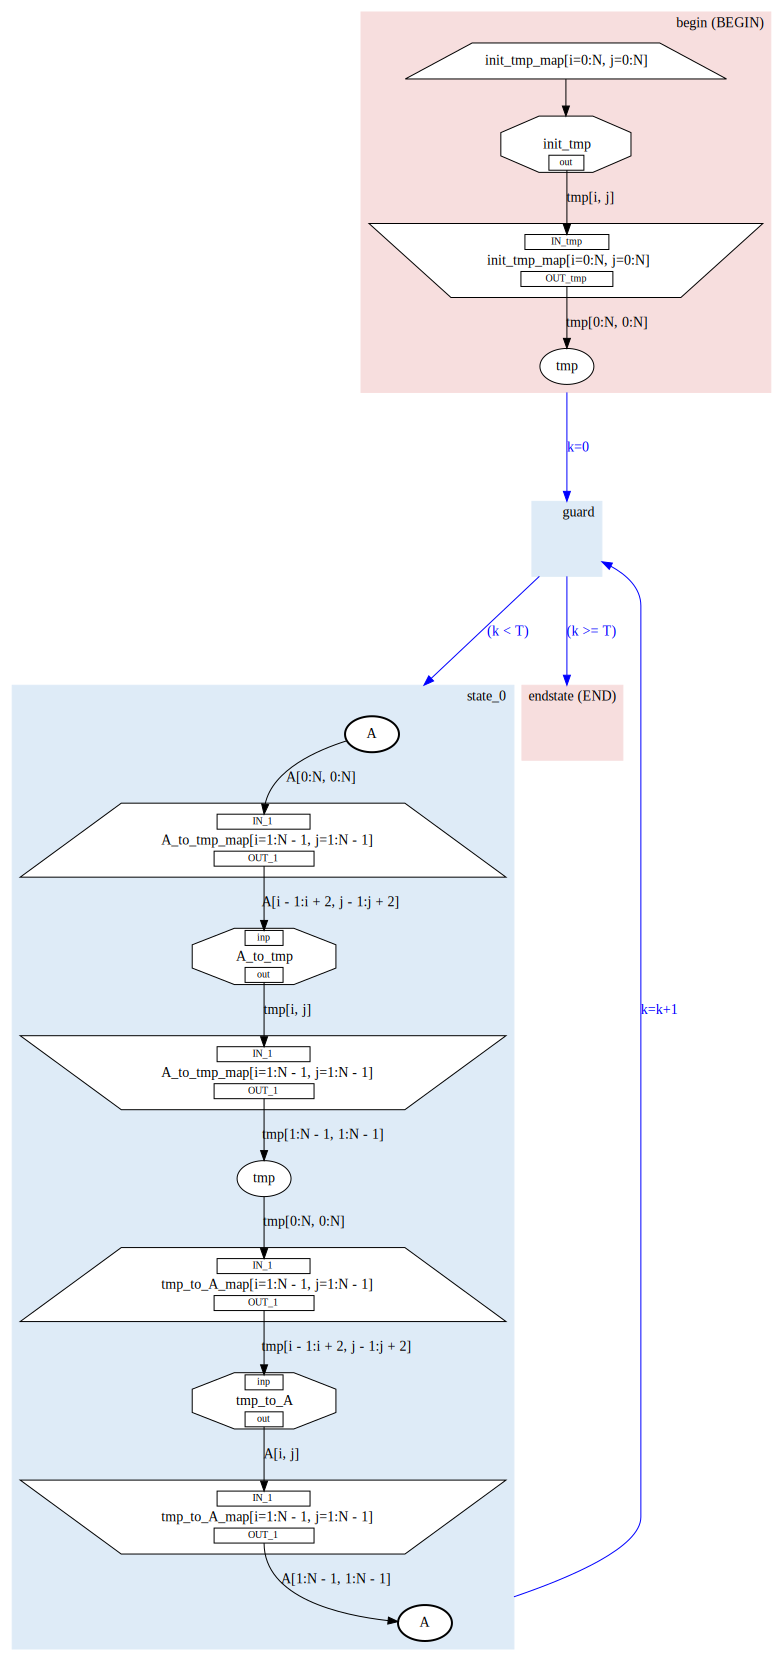

In [12]:
guard = sdfg.add_state('guard')
endstate = sdfg.add_state('endstate')

# State connection (control flow)

# Note: dataflow (arrays) CAN affect control flow assignments and conditions,
#       but not the other way around (you cannot change an interstate variable
#       inside a state). The following code works as well:
#sdfg.add_edge(state0, guard, dace.InterstateEdge(assigments=dict('k', 'A[0]')))

# Loop initialization (k=0)
sdfg.add_edge(bstate, guard, dace.InterstateEdge(assignments=dict(k='0')))

# Loop condition (k < T / k >= T)
sdfg.add_edge(guard, state, dace.InterstateEdge('k < T'))
sdfg.add_edge(guard, endstate, dace.InterstateEdge('k >= T'))

# Loop incrementation (k++)
sdfg.add_edge(
    state, guard, dace.InterstateEdge(assignments=dict(k='k+1')))

# Display resulting SDFG
sdfg

And the SDFG is complete. Now all that is left is to execute it and validate the results:

In [13]:
from scipy import ndimage

# Symbol values
N = 24
T = 5

# Arrays
inp = np.zeros(shape=(N, N), dtype=np.float32)
inp[1:N-1, 1:N-1] = np.random.rand(N-2, N-2).astype(np.float32)
expected = np.copy(inp[1:N-1, 1:N-1])
kernel = np.array([[0, 0.2, 0], [0.2, 0.2, 0.2], [0, 0.2, 0]], dtype=np.float32)

# Evaluate expected result
for k in range(T * 2):
    expected = ndimage.convolve(
            expected, kernel, mode='constant', cval=0.0)

In [14]:
sdfg(A=inp, N=N, T=T)

0. Pattern FPGATransformSDFG in jacobi2d
1. Pattern FPGATransformState in state_0
2. Pattern FPGATransformState in begin
3. Pattern FPGATransformState in guard
4. Pattern FPGATransformState in endstate
5. Pattern GPUTransformSDFG in jacobi2d
6. Pattern NestSDFG in jacobi2d
7. Pattern FPGATransformMap in A_to_tmp_map[i=1:N - 1, j=1:N - 1]
8. Pattern FPGATransformMap in tmp_to_A_map[i=1:N - 1, j=1:N - 1]
9. Pattern GPUTransformLocalStorage in A_to_tmp_map[i=1:N - 1, j=1:N - 1]
10. Pattern GPUTransformLocalStorage in tmp_to_A_map[i=1:N - 1, j=1:N - 1]
11. Pattern GPUTransformMap in A_to_tmp_map[i=1:N - 1, j=1:N - 1]
12. Pattern GPUTransformMap in tmp_to_A_map[i=1:N - 1, j=1:N - 1]
13. Pattern MapExpansion in A_to_tmp_map: ['i', 'j']
14. Pattern MapExpansion in tmp_to_A_map: ['i', 'j']
15. Pattern MapFusion in A_to_tmp_map: ['i', 'j'] -> tmp_to_A_map: ['i', 'j']
16. Pattern MapTiling in A_to_tmp_map: ['i', 'j']
17. Pattern MapTiling in tmp_to_A_map: ['i', 'j']
18. Pattern StripMining in A_

0

In [15]:
print('Difference:', np.linalg.norm(expected - inp[1:N-1, 1:N-1]))

Difference: 1.7447289e-06
